#### This notebook contains code to plot a set of model output datasets and compare for the best performance. This includes:
 A. Daily surface height change from GNSS-IR

 B. Hourly snow temperatures from iButtons

 C. Seasonal mass balance from stakes

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from plotting_fxns import *
from sklearn.metrics import mean_squared_error

Open datasets and create list of labels

In [3]:
dslist = []
labels = []
for i in range(0,81):
    label = ''
    fp = f'/home/claire/research/Output/calibration/Gulkana_cal{i}.nc'
    ds,startdate,enddate = getds(fp)
    ice_exposed = ds.isel(time=np.where(ds['snowdepth'].values == 0)[0])
    ice_time = ice_exposed.coords['time'].values[0]
    dslist.append(ds)
    label += r'$\alpha$='+str(ds.attrs['aice']) + ', '
    label += r'$k_{sp}$='+str(ds.attrs['ksp_BC']) + ', '
    label += r'$k_{ice}$='+str(ds.attrs['k_ice']) + ', '
    label += r'$f_{dep}$='+str(ds.attrs['dep_factor'])
    labels.append(label)

In [64]:
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df.index = pd.to_datetime(stake_df['Date'])
dates_index = pd.date_range(startdate,enddate) - pd.Timedelta(minutes=30)
stake_df = stake_df.loc[dates_index]

Compare summer-long dh

KeyboardInterrupt: 

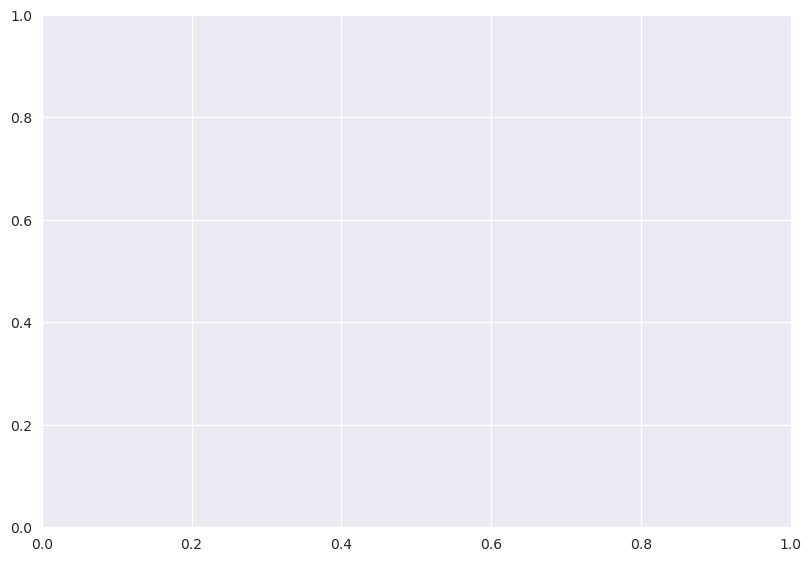

In [5]:
fig,ax = plt.subplots(layout='constrained')
plot_time = pd.date_range(startdate,enddate,freq='h')
c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
lowest_rmse = 1e10
for i,ds in enumerate(dslist):
    try:
        c = next(c_iter)
    except:
        c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
        c = next(c_iter)
    ds = ds.sel(time=plot_time,bin=0).resample(time='d').sum()
    dh = ds.dh.cumsum().to_numpy() - ds.dh.to_numpy()[0]

    melt_mse = mean_squared_error(dh,stake_df['CMB'])
    melt_rmse = np.mean(melt_mse)
    if melt_rmse < lowest_rmse:
        lowest_rmse = melt_rmse
        best_idx = i
        dh_best = dh
    else:
        ax.plot(ds.coords['time'],dh,label=labels[i],color=c,linewidth=0.8)
ax.plot(ds.coords['time'],dh_best,label=labels[i],color='red',linewidth=1.5)
ax.plot(stake_df.index,stake_df['CMB'].to_numpy(),label='Stake',linestyle='--',color='black')
date_form = mpl.dates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(date_form)
if len(dslist) < 9:
    ax.legend()
ax.set_ylabel('Surface Height Change [m]')
fig.suptitle(f'Best model: {labels[best_idx]}')
plt.show()

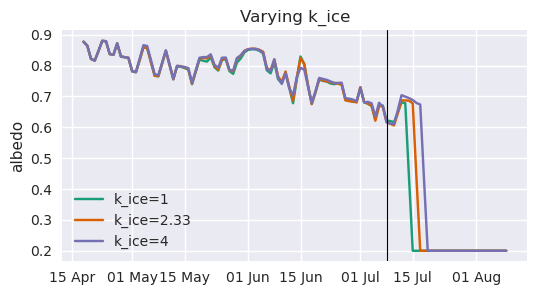

In [6]:
vary = 'k_ice'
new_list = []
new_labels = []
for i,ds in enumerate(dslist):
    ksp = ds.attrs['ksp_BC']
    aice = ds.attrs['aice']
    dep = ds.attrs['dep_factor']
    kice = ds.attrs['k_ice']
    if dep == 0.5 and ksp == 0.2 and aice == 0.2: #kice == 2.33
        new_list.append(ds)
        new_labels.append(vary+'='+str(ds.attrs[vary]))
compare_runs(new_list,[startdate,enddate],new_labels,'albedo')
# plt.plot(stake_df.index,stake_df['CMB'].to_numpy(),label='Stake',linestyle='--',color='black',alpha=0.6)
plt.axvline(pd.to_datetime('2023-07-08'),linewidth=0.8,color='black')
plt.title(f'Varying {vary}')
plt.legend()
plt.show()

Compare layer temperatures at chosen dates

In [37]:
hours = pd.date_range(startdate,'2023-05-19 00:30',freq='h')
hours_onhour  = hours - pd.Timedelta(minutes=30)

In [38]:
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv')
temp_df = temp_df.set_index(pd.to_datetime(temp_df['Datetime']))
temp_df = temp_df.drop(columns='Datetime')
measure_height_all = 3.5 - np.array([.1,.4,.8,1.2,1.6,2,2.4,2.8,3.2,3.49])

In [39]:
ds_all = xr.Dataset(dict(
    model_temp=(['time','layer'],np.ones((len(hours),len(measure_height_all)))),
    measure_temp=(['time','layer'],temp_df.loc[hours_onhour].to_numpy())),
    coords=dict(time=(['time'],hours),
                layer=(['layer'],measure_height_all)))
print(ds_all)

<xarray.Dataset>
Dimensions:       (time: 745, layer: 10)
Coordinates:
  * time          (time) datetime64[ns] 2023-04-18T00:30:00 ... 2023-05-19T00...
  * layer         (layer) float64 3.4 3.1 2.7 2.3 1.9 1.5 1.1 0.7 0.3 0.01
Data variables:
    model_temp    (time, layer) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    measure_temp  (time, layer) float64 -7.771 -8.0 -8.0 -8.0 ... -2.0 -2.5 -2.0


In [71]:
# def get_temp_stats(ds,temp_df,hours,plot=False):
for afj in [0]:

    for hour in hours:
        # interpolate measurements to match MERRA-2 timestamps
        time_index = [hour-pd.Timedelta(minutes=30), hour+pd.Timedelta(minutes=30)]
        measure_temp = np.mean(temp_df.loc[time_index].to_numpy(),axis=0)
        measure_height = measure_height_all

        # index dataset by time and variable
        model_temp_all = ds.sel(time=hour,bin=0)['layertemp'].to_numpy()
        model_dz_all = ds.sel(time=hour,bin=0)['layerheight'].to_numpy()
        model_dens = ds.sel(time=hour,bin=0)['layerdensity'].to_numpy()
        
        # index snow layers
        model_dens[np.where(np.isnan(model_dens))[0]] = 1e5
        snow = np.where(model_dens < 700)[0]
        assert len(snow) >= 1, f'no snow at {hour}'
        
        # get height of layers above ice
        model_dz = model_dz_all[snow]
        icedepth = np.sum(model_dz) + model_dz[-1] / 2
        above_ground = np.array([np.sum(model_dz[:i+1])-(model_dz[i]/2) for i in range(len(model_dz))])
        model_height = icedepth - above_ground
        print('model',model_height)
        print('measure',measure_height)

        # store interpolated model temps
        model_temp = model_temp_all[snow]
        model_temp_interp = np.interp(measure_height,model_height,model_temp)
        ds_all['model_temp'].loc[hour,:] = model_temp_interp

model [2.54013128 2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.5403276  2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.54048031 2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.5406296  2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.54084295 2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.54119434 2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5  1.1  0.7  0.3  0.01]
model [2.54169865 2.47327591 2.36410083 2.18410156 1.88733293 1.39804418
 0.72898789]
measure [3.4  3.1  2.7  2.3  1.9  1.5 

In [69]:
print(ds.sel(time=hour,bin=0)['snowdepth'].values)

<xarray.DataArray 'snowdepth' ()>
array(1.925904)
Coordinates:
    time     datetime64[ns] 2023-05-19T00:30:00
    bin      int64 0
Attributes:
    units:    m


4.879618877228921


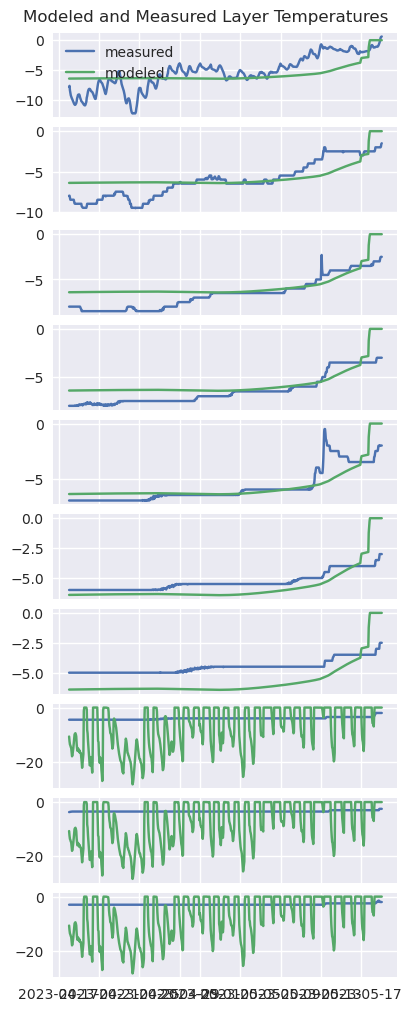

In [57]:
mse = mean_squared_error(ds_all['measure_temp'].values,ds_all['model_temp'].values)
rmse = np.sqrt(mse)
print(rmse)
fig,ax = plt.subplots(10,sharex=True,layout='constrained',figsize=(4,10))
for i in range(10):
    ds_plot = ds_all.isel(layer=i) #.mean('layer')
    ax[i].plot(ds_all.coords['time'],ds_plot['measure_temp'],label='measured')
    ax[i].plot(ds_all.coords['time'],ds_plot['model_temp'],label='modeled')
ax[0].legend(loc='upper left')
fig.suptitle('Modeled and Measured Layer Temperatures')
plt.show()

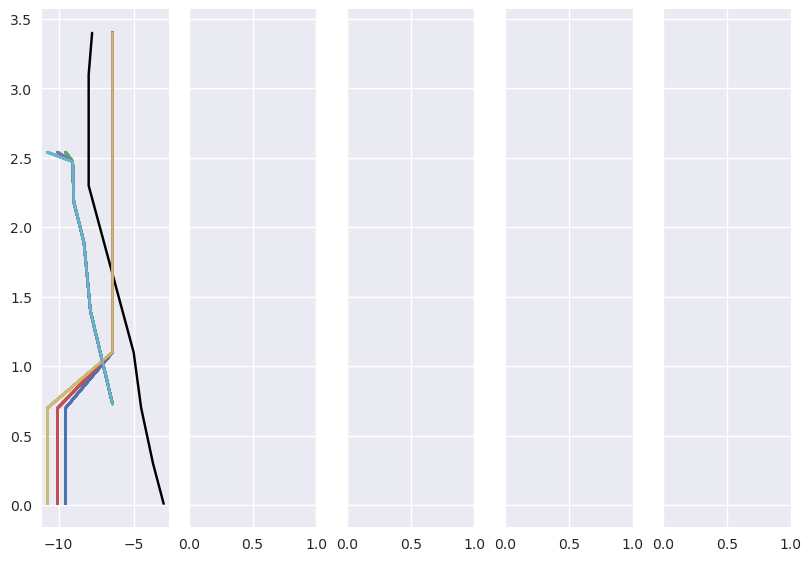

In [55]:
fig,axes = plt.subplots(1,len(dates),layout='constrained',sharey=True)
for d,date in enumerate(dates):
    measure_temp = temp_df.loc[date - pd.Timedelta(minutes = 30)].to_numpy()
    subsurf_idx = np.where(measure_temp <= 0.5)[0]
    measure_temp = measure_temp[subsurf_idx]
    measure_height = measure_height_all[subsurf_idx]
    ax = axes[d]
    ax.plot(measure_temp,measure_height,label='Measured',color='black')
    for i,ds in enumerate(dslist):
        model_temp_all = ds.sel(time=date,bin=0)['layertemp'].to_numpy()
        model_dz_all = ds.sel(time=date,bin=0)['layerheight'].to_numpy()
        # Index snow bins
        model_dens = ds.sel(time=date,bin=0)['layerdensity'].to_numpy()
        model_dens[np.where(np.isnan(model_dens))[0]] = 1e5
        snowbins = np.where(model_dens < 700)[0]
        assert len(snowbins) >= 1, f'no snow at {date}'
        # Get height of bins above ice
        model_dz = model_dz_all[snowbins]
        icedepth = np.sum(model_dz) + model_dz[-1] / 2
        above_ground = np.array([np.sum(model_dz[:i+1])-(model_dz[i]/2) for i in range(len(model_dz))])
        model_height = icedepth - above_ground

        # Get model temp and RMSE
        model_temp = model_temp_all[snowbins]
        model_temp_interp = np.interp(measure_height,model_height,model_temp)
        temp_mse = mean_squared_error(model_temp_interp,measure_temp)
        temp_rmse = np.mean(temp_mse)

        ax.plot(model_temp_interp,measure_height,label='Interpolate')
        ax.plot(model_temp,model_height,label=f'RMSE: {temp_rmse}')
    # axes[0].legend()
    plt.show()
        

In [1]:
df = pd.read_csv('/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv')
for site in np.unique(df['site_name']):
    df_site = df.loc[df['site_name'] == site]
    first = df_site.Year.iloc[0]
    last = df_site.Year.iloc[-1]
    plt.plot(df_site.Year,df_site.ba,label=f'{site}: {first}-{last}')
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(1966,2022)
plt.ylabel('Annual Mass Balance (m w.e.)')

NameError: name 'pd' is not defined

In [ ]:
    # w = 2 # width of each plot
    # n = int(np.ceil(len(ds_list)/2))
    # n = 2 if n == 1 else n

    # # Initialize plots
    # fig,ax = plt.subplots(rows,int(n/rows),sharex=True,figsize=(w*n/rows,6),layout='constrained')
    # ax = ax.flatten()

    # # Initialize time and comparison dataset
    # if len(time) == 2:
    #     start = pd.to_datetime(time[0])
    #     end = pd.to_datetime(time[1])
    #     time = pd.date_range(start,end,freq='h')
    # temp_df = temp_df.set_index(pd.to_datetime(temp_df['Datetime']))
    # temp_df = temp_df.drop(columns='Datetime')
    # height_DATA = 3.5 - np.array([.1,.4,.8,1.2,1.6,2,2.4,2.8,3.2,3.49])

    # c_iter = iter(plt.cm.Dark2(np.linspace(0,1,8)))
    # date_form = mpl.dates.DateFormatter('%d %b')
    # plot_idx = 0
    # for i,ds in enumerate(ds_list):
    #     # get variable and value for labeling
    #     var,val = labels[i].split('=')

    #     # Need to interpolate data for comparison to model depths -- loop through timesteps
    #     all_MODEL = np.array([])
    #     all_DATA = np.array([])
    #     all_TIME = np.array([])
    #     plot_MODEL = np.array([])
    #     plot_DATA = np.array([])
    #     for hour in time:
    #         # Extract layer heights
    #         lheight = ds.sel(time=hour,bin=0)['layerheight'].to_numpy()
    #         # Index snow bins
    #         density = ds.sel(time=hour,bin=0)['layerdensity'].to_numpy()
    #         density[np.where(np.isnan(density))[0]] = 1e5
    #         full_bins = np.where(density < 700)[0]
    #         if len(full_bins) < 1:
    #             break
    #         lheight = lheight[full_bins]
    #         icedepth = np.sum(lheight) + lheight[-1] / 2

    #         # Get property and absolute depth
    #         temp_MODEL = ds.sel(time=hour,bin=0)['layertemp'].to_numpy()[full_bins]
    #         ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
    #         height_above_ice = icedepth - ldepth

    #         # Interpolate temperature data to model heights
    #         temp_at_iButtons = temp_df.loc[hour].to_numpy().astype(float)
    #         temp_DATA = np.interp(height_above_ice,height_DATA,temp_at_iButtons)
    #         all_MODEL = np.append(all_MODEL,temp_MODEL)
    #         all_DATA = np.append(all_DATA,temp_DATA)
    #         all_TIME = np.append(all_TIME,hour)

    #         # Extract mean snow column temperature to plot
    #         temp_no_above_0 = temp_df.mask(temp_df>=0.2,None).loc[hour].to_numpy().astype(float)
    #         plot_MODEL = np.append(plot_MODEL,np.average(temp_MODEL,weights=lheight))
    #         plot_DATA = np.append(plot_DATA,np.mean(temp_no_above_0))
    #     temp_mse = mean_squared_error(all_DATA,all_MODEL)
    #     temp_rmse = np.mean(temp_mse)
    #     label = f'{val}: {temp_rmse:.3f}'

    #     # get color (loops itself)
    #     try:
    #         c = next(c_iter)
    #     except:
    #         c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    #         c = next(c_iter)

    #     # plot temp_df once per plot
    #     if i % 2 == 0:
    #         ax[plot_idx].plot(all_TIME,plot_DATA,label='iButtons',linestyle='--')

    #     # plot daily melt
    #     time = pd.date_range(time[0],end,freq='h')
    #     ax[plot_idx].plot(all_TIME,plot_MODEL,label=label,color=c,linewidth=0.8)
    #     ax[plot_idx].set_title(var)
    #     ax[plot_idx].xaxis.set_major_formatter(date_form)
    #     ax[plot_idx].set_ylabel('Average Snow Temperature (C)')
    #     ax[plot_idx].legend()

    #     if i % 2 != 0:
    #         plot_idx += 1
    # fig.suptitle(t)
    # plt.show()